In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "SRS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn025861,MNDNPINPAIIGKARQKRKKSIIPNEKPVFVPVINSRKEKNRKEKE...,280,1
1,Achn049041,MSGFFSLGGKQEKSTTTNSLFLLRNEEIYNKSFELWQQYYHLHQQK...,280,1
2,Achn084931,MSAVVATTRRFPSDSGAFADWVASSSSSGPRATEDLSLGFNAGGGS...,390,1
3,Achn131151,MRPGMNCQDCGNQAKKDCVHLRCRTCCKSWGLPCQTHVKSTWVPAA...,210,1
4,Achn135131,MAGFFSLGGGRETNTNDQDHQQQTQNPNNPVAEISPENWFLYRNED...,318,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1516,0.020501,0.002278,0.011390,0.004556,0.000000,0.006834,0.006834,0.000000,0.000000,0.002278,...,0.002278,0.000000,0.000000,0.006834,0.004556,0.0,0.0,0.000000,0.0,0.0
187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004975,0.004975,0.000000,...,0.000000,0.000000,0.004975,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
413,0.010989,0.000000,0.000000,0.000000,0.005495,0.000000,0.005495,0.000000,0.005495,0.005495,...,0.000000,0.000000,0.005495,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2148,0.000000,0.000000,0.003003,0.000000,0.000000,0.006006,0.000000,0.006006,0.006006,0.003003,...,0.000000,0.003003,0.000000,0.003003,0.000000,0.0,0.0,0.003003,0.0,0.0
2,0.020566,0.000000,0.005141,0.000000,0.002571,0.010283,0.000000,0.000000,0.002571,0.002571,...,0.000000,0.000000,0.002571,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2103, 440)
X_test: (526, 440)
y_train: (2103,)
y_test: (526,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,161 (610.00 KB)

 Trainable params: 156,161 (610.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 12s 470ms/step - accuracy: 0.5625 - loss: 0.6929

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7219 - loss: 0.6805 - val_accuracy: 0.9335 - val_loss: 0.5621


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.5599

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - loss: 0.4388 - val_accuracy: 0.9335 - val_loss: 0.1764


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1192

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9509 - loss: 0.1464 - val_accuracy: 0.9715 - val_loss: 0.0897


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1294

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.0783 - val_accuracy: 0.9857 - val_loss: 0.0424


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0173

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0293 - val_accuracy: 0.9810 - val_loss: 0.0537


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0631

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0439 - val_accuracy: 0.9905 - val_loss: 0.0290


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0941

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0298 - val_accuracy: 0.9905 - val_loss: 0.0317


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0127

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.9881 - val_loss: 0.0330


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0126

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0129 - val_accuracy: 0.9881 - val_loss: 0.0315


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0136

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0115 - val_accuracy: 0.9905 - val_loss: 0.0218


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0051

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0068 - val_accuracy: 0.9905 - val_loss: 0.0200


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0025

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0051 - val_accuracy: 0.9929 - val_loss: 0.0253


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4345e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0063 - val_accuracy: 0.9905 - val_loss: 0.0190


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9905 - val_loss: 0.0195


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6816e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9905 - val_loss: 0.0199


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0022

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0032 - val_accuracy: 0.9905 - val_loss: 0.0267


Epoch 17/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9929 - val_loss: 0.0244


Epoch 18/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0500e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9905 - val_loss: 0.0348


Epoch 19/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0025

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9952 - val_loss: 0.0225


Epoch 20/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8942e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9905 - val_loss: 0.0238


Epoch 21/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1331e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.6770e-04 - val_accuracy: 0.9905 - val_loss: 0.0249


Epoch 22/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0742e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3975e-04 - val_accuracy: 0.9905 - val_loss: 0.0245


Epoch 23/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0952e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.5607e-04 - val_accuracy: 0.9905 - val_loss: 0.0250


Epoch 24/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8032e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.0263e-04 - val_accuracy: 0.9905 - val_loss: 0.0250


Epoch 25/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6754e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.9064e-04 - val_accuracy: 0.9905 - val_loss: 0.0251


Epoch 26/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2805e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.4542e-04 - val_accuracy: 0.9905 - val_loss: 0.0250


Epoch 27/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4232e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6304e-04 - val_accuracy: 0.9905 - val_loss: 0.0261


Epoch 28/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0019

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.6404e-04 - val_accuracy: 0.9905 - val_loss: 0.0262


Epoch 29/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0465e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9285e-04 - val_accuracy: 0.9905 - val_loss: 0.0262



[Train Accuracy: 100.00% - Test Accuracy: 99.05%]


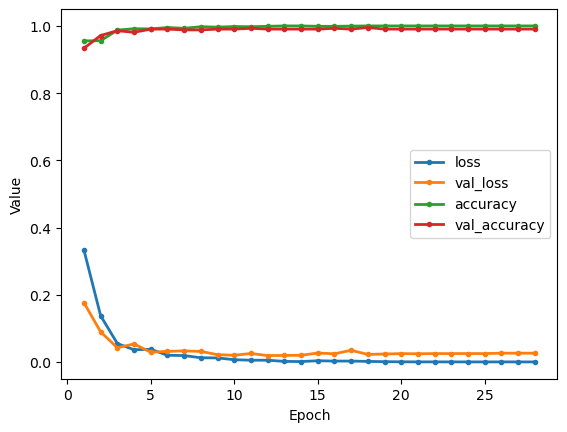

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1516,0.011416,0.0,0.002283,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.000000,0.0,0.000000,0.0,0.005525,0.000000,0.005525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2148,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002577,0.0,0.002577,0.0,0.000000,0.002577,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2103, 8498)
X_test: (526, 8498)
y_train: (2103,)
y_test: (526,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,175,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,219,009 (8.46 MB)

 Trainable params: 2,219,009 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.5156 - loss: 0.6931

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5050 - loss: 0.6919   

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5805 - loss: 0.6863

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6324 - loss: 0.6773 - val_accuracy: 0.9715 - val_loss: 0.4798


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.4283

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9735 - loss: 0.4211 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9767 - loss: 0.3753

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9787 - loss: 0.3338 - val_accuracy: 0.9834 - val_loss: 0.0600


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0208

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0205 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0191

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0182 - val_accuracy: 0.9857 - val_loss: 0.0283


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0040

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0033 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0029

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 0.9881 - val_loss: 0.0274


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0014

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9881 - val_loss: 0.0570


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.9553e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4728e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0526e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2445e-04 - val_accuracy: 0.9881 - val_loss: 0.0558


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.9643e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8375e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9740e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2697e-04 - val_accuracy: 0.9881 - val_loss: 0.0449


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 6.8369e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1150e-04 

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7337e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5349e-04 - val_accuracy: 0.9881 - val_loss: 0.0684


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0015

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7642e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5258e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0308e-04 - val_accuracy: 0.9881 - val_loss: 0.0691


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.5773e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.8983e-04 

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1019e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0881e-04 - val_accuracy: 0.9881 - val_loss: 0.0517


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.2536e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0984e-04 

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1120e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1016e-04 - val_accuracy: 0.9881 - val_loss: 0.0598


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.7342e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1436e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1355e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1699e-04 - val_accuracy: 0.9881 - val_loss: 0.0641


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6252e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1679e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1978e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2312e-04 - val_accuracy: 0.9881 - val_loss: 0.0614


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.5952e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7956e-04 

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7124e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6505e-04 - val_accuracy: 0.9881 - val_loss: 0.0629



[Train Accuracy: 100.00% - Test Accuracy: 99.62%]


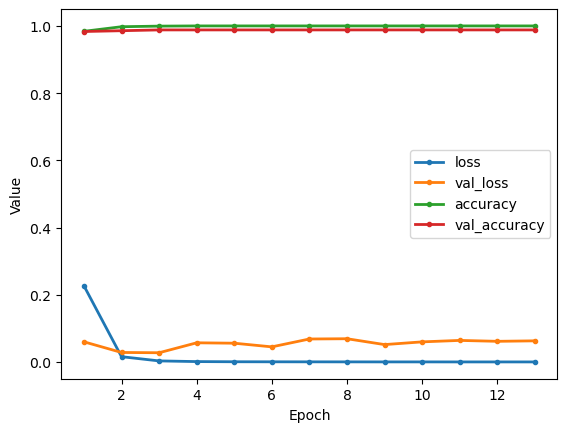

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1516,0.002288,0.0,0.002288,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2148,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.002584,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      30,953,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,994,433 (118.23 MB)

 Trainable params: 30,994,433 (118.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 17s 662ms/step - accuracy: 0.5312 - loss: 0.6931

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5156 - loss: 0.6931  

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5191 - loss: 0.6931

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5221 - loss: 0.6930

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5208 - loss: 0.6929

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5169 - loss: 0.6929

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5132 - loss: 0.6928

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5157 - loss: 0.6927

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5219 - loss: 0.6926

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5305 - loss: 0.6925

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5396 - loss: 0.6923

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5484 - loss: 0.6921

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5562 - loss: 0.6919

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5640 - loss: 0.6916

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5720 - loss: 0.6914

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5799 - loss: 0.6911

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5878 - loss: 0.6907

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5958 - loss: 0.6904

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6034 - loss: 0.6900

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6108 - loss: 0.6895

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6179 - loss: 0.6891

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6245 - loss: 0.6886

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6309 - loss: 0.6880

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6370 - loss: 0.6874

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6428 - loss: 0.6867

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6483 - loss: 0.6860

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6536 - loss: 0.6854

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.6585 - loss: 0.6847 - val_accuracy: 0.9572 - val_loss: 0.5761


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9375 - loss: 0.5844

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9453 - loss: 0.5756

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9531 - loss: 0.5693

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9561 - loss: 0.5652

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9580 - loss: 0.5613

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9593 - loss: 0.5570

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9597 - loss: 0.5530

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9596 - loss: 0.5488

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9597 - loss: 0.5446

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9601 - loss: 0.5400

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9606 - loss: 0.5353

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9611 - loss: 0.5308

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9616 - loss: 0.5262

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9622 - loss: 0.5213

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9628 - loss: 0.5162

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9631 - loss: 0.5113

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9634 - loss: 0.5062

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9637 - loss: 0.5012

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9640 - loss: 0.4962

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9643 - loss: 0.4912

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9645 - loss: 0.4861

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9649 - loss: 0.4810

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9652 - loss: 0.4759

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9655 - loss: 0.4708

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9659 - loss: 0.4657

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9663 - loss: 0.4606

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9669 - loss: 0.4514 - val_accuracy: 0.9929 - val_loss: 0.0771


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0430

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9961 - loss: 0.0452

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9939 - loss: 0.0475

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9935 - loss: 0.0479

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9935 - loss: 0.0479

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9937 - loss: 0.0473

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9940 - loss: 0.0467

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9940 - loss: 0.0460

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9941 - loss: 0.0453

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9942 - loss: 0.0445

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9944 - loss: 0.0436

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9945 - loss: 0.0427

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9947 - loss: 0.0419

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9948 - loss: 0.0411

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9949 - loss: 0.0404

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9951 - loss: 0.0396

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9952 - loss: 0.0389

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9953 - loss: 0.0382

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9954 - loss: 0.0375

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9955 - loss: 0.0368

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9957 - loss: 0.0362

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9958 - loss: 0.0356

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9958 - loss: 0.0350

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9959 - loss: 0.0345

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9960 - loss: 0.0340

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9961 - loss: 0.0335

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9962 - loss: 0.0326 - val_accuracy: 0.9952 - val_loss: 0.0123


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 0.0030

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0029

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0029

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0029

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0029

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0029

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0029

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0030

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0031

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0031

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0032

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0032

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0032

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0032

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0032

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0031

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9952 - val_loss: 0.0129


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 6.8037e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 7.2452e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 7.5414e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 8.1882e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 8.6575e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 8.9860e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.2049e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.4044e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.6010e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.7428e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8301e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9069e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9527e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9656e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9564e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9334e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.8909e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.8468e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.8866e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9098e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9337e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9517e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9728e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.9885e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0010    

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0010

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9952 - val_loss: 0.0079


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 6.6986e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.8330e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.9981e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 7.0835e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 7.0869e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.9912e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.9361e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.8976e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.8255e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.7745e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.7122e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.6564e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.6355e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.6021e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.5699e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.5446e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.5167e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.4897e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.4636e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.4398e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.4156e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 6.3929e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.3671e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 6.3396e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 6.3105e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 6.2844e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 6.2351e-04 - val_accuracy: 0.9952 - val_loss: 0.0087


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.1418e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.8939e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.0320e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.0550e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.1187e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.1712e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.2236e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.3073e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.3577e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.4230e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.4674e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.4928e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5210e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5373e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5540e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5665e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5778e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.5974e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.6184e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6404e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6557e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6652e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6713e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6769e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6862e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.6922e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 3.7019e-04 - val_accuracy: 0.9952 - val_loss: 0.0106


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.6192e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.8457e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.0442e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.0343e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.0025e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.9682e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.9199e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.8608e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.8139e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.7902e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.7616e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.7352e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.7129e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.6886e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.6689e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6462e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6280e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.6183e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.6067e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5943e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5872e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5780e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5688e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5622e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5548e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.5465e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 1.0000 - loss: 2.5330e-04 - val_accuracy: 0.9952 - val_loss: 0.0097


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.1467e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.9633e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.0787e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.1487e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.1708e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.1549e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.1323e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.0976e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.0575e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.0452e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.0537e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.0681e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.0766e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.0894e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.0988e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1044e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1065e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1075e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1068e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1084e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1090e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1086e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1078e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 2.1054e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1032e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1007e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 2.0959e-04 - val_accuracy: 0.9952 - val_loss: 0.0086


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 2.3365e-04

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 2.1213e-04

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 1.9228e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.8153e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.7364e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 1.6973e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 1.6737e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 1.6872e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 1.6902e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 1.6858e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 1.6760e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 1.6651e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 1.6556e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 1.6446e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 1.6350e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 1.6285e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 1.6199e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 1.6121e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 1.6035e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 1.5953e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 1.5872e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 1.5785e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5708e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 1.5630e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5568e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.5504e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 1.5381e-04 - val_accuracy: 0.9952 - val_loss: 0.0104


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 7.6994e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.6496e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.0292e-04

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.1054e-04

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.1199e-04

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1163e-04

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1297e-04

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1335e-04

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1323e-04

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1254e-04

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.1299e-04

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1370e-04

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1439e-04

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1480e-04

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1482e-04

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1521e-04

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1568e-04

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1611e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1685e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1743e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1784e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1819e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1844e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1867e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1879e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1881e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 1.1878e-04 - val_accuracy: 0.9952 - val_loss: 0.0098


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 8.6830e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 8.1106e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 8.5772e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 9.3783e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.7267e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.7983e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8283e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8702e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8542e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8875e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 9.8756e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.8351e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.7842e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.7163e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.6362e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.5658e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.5061e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.4471e-05

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.4132e-05

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3901e-05

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3771e-05

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3654e-05

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3472e-05

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3409e-05

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3362e-05

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 9.3274e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 9.3202e-05 - val_accuracy: 0.9952 - val_loss: 0.0100


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 7.5197e-05

 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 6.7668e-05

 3/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.4713e-05

 4/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.3527e-05

 5/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.2947e-05

 6/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.3430e-05

 7/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.4126e-05

 8/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.4469e-05

 9/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.6690e-05

10/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 6.8986e-05

11/27 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 7.1073e-05

12/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 7.8905e-05

13/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 8.4996e-05

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 8.9715e-05

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.3411e-05

16/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.6234e-05

17/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.8353e-05

18/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0009e-04

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.0136e-04

20/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0227e-04

21/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0298e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0361e-04

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0422e-04

24/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0471e-04

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0540e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0590e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.0681e-04 - val_accuracy: 0.9952 - val_loss: 0.0074



[Train Accuracy: 100.00% - Test Accuracy: 99.43%]


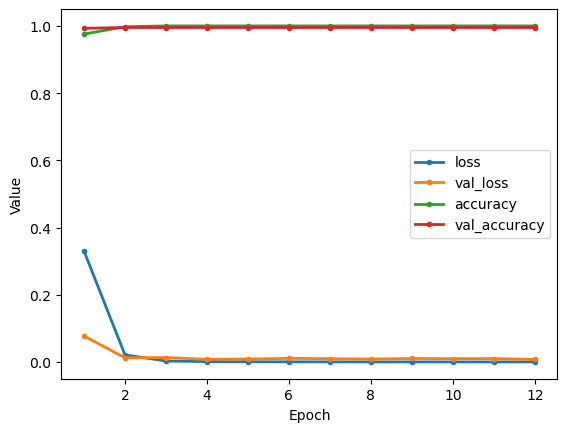

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

 8/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/SRS/report_4HIUGW2Q.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################